In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Set random seed for reproducibility
torch.manual_seed(42)


In [20]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28,1024)
        self.fc2 = nn.Linear(1024, 10, bias=True)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return x

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Instantiate the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1

# import os
# if not os.path.exists('mnist_model.pt'):
#     #train
#     print('training.. ')
#     for epoch in range(num_epochs):
#         for images, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     torch.save(model,'mnist_model.pt')
# else:
#     print('loading..')
#     model = torch.load('mnist_model.pt')

# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 9.80%


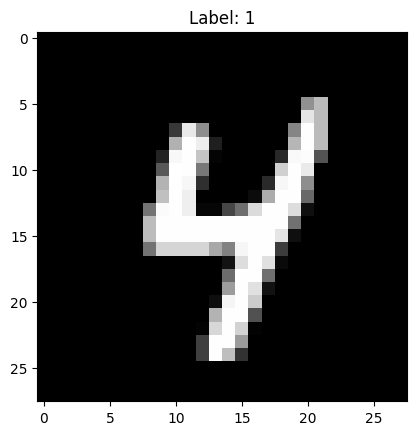

In [21]:
x, y = images[3].unsqueeze(0), labels[0].unsqueeze(0)
plt.imshow(x.numpy().squeeze(), cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()


In [22]:
out  = model(x)
loss = criterion(out,y)
dldw_target = torch.autograd.grad(loss, model.fc2.weight)[0]

print('dldw norm:',dldw_target.norm())
# model = zero_grad(model)

dldw norm: tensor(15.9061)


In [23]:
x_hat = torch.nn.Parameter(torch.rand_like(x),requires_grad=True)
# x_hat = torch.nn.Parameter(images[1].unsqueeze(0),requires_grad=True)
# x_hat_sm = torch.softmax(x_hat)
# x_hat = torch.nn.Parameter(x.data,requires_grad=True)

In [18]:
# out_hat  = model(x_hat)
# loss_hat = criterion(out_hat,y)
# dldw_hat = torch.autograd.grad(loss_hat, model.fc2.weight)[0]
# print('dldw_hat norm:',dldw_hat.norm())

In [24]:
def meta_loss(x, y, model, dldw_target):
    logits = model(x)
    loss   = criterion(logits, y)
    dldw   = torch.autograd.grad(loss, model.fc2.weight, create_graph=True)[0]
    return torch.sum((dldw-dldw_target)**2), dldw

In [25]:
mloss, dldw_f = meta_loss(x=x_hat, y=y, model=model, dldw_target=dldw_target)
print('metaloss:', mloss)

metaloss: tensor(34.0615, grad_fn=<SumBackward0>)


In [26]:
lr = .1
prev_mloss = float('inf')  # Initialize with a large value
no_improvement_count = 0
lr_reduction_factor = 2.0

i=0
while True:
    if i >5000: break
    mloss, dldw_f = meta_loss(x=x_hat, y=y, model=model, dldw_target=dldw_target)
    grad = torch.autograd.grad(mloss, x_hat)[0]

    if i % 10 == 0 or i <10:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:3d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), lr))

    # Check if meta loss has not improved for the last 1000 iterations
    if i > 1000 and mloss >= prev_mloss:
        no_improvement_count += 1
        if no_improvement_count >= 1000:
            lr /= lr_reduction_factor  # Reduce learning rate by half
            no_improvement_count = 0  # Reset no improvement counter

    x_hat = x_hat - lr * grad
    prev_mloss = mloss  # Update previous meta loss for the next iteration
    i+=1


Iteration, Loss, Gradient Norm, Learning Rate:   0, 34.0615, 2.2529, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   1, 33.5558, 2.2365, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   2, 33.0574, 2.2201, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   3, 32.5663, 2.2037, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   4, 32.0825, 2.1872, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   5, 31.6059, 2.1707, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   6, 31.1365, 2.1543, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   7, 30.6742, 2.1378, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   8, 30.2190, 2.1213, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:   9, 29.7707, 2.1048, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  10, 29.3294, 2.0884, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  20, 25.2839, 1.9258, 0.1000
Iteration, Loss, Gradient Norm, Learning Rate:  30, 21.8567, 1.7692, 0.1000
Iteration, L

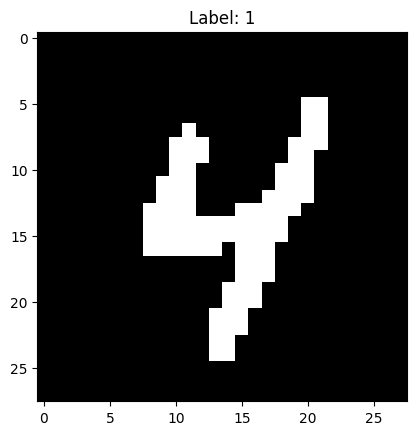

In [27]:
x_rec = torch.sigmoid(x_hat) > .5
plt.imshow(x_rec.detach().numpy().squeeze(), cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()